In [16]:
%load_ext autoreload
%autoreload 2
import torch 
from torch import nn
from omegaconf import OmegaConf
import timm
from ml_utilities.output_loader.result_loader import JobResult
from ml_utilities.data.datasetgenerator import DatasetGenerator
from ml_utilities.data.data_utils import show_image_grid
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tflearning.sample_difficulty import prediction_depth as pdepth
from sklearn.neighbors import KNeighborsClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
job_cf10resnet = JobResult('/system/user/beck/pwbeck/projects/regularization/tflearning/outputs/IA-A-cifar10-17.2.2-resnet-B--230204_215821')
job_cf10resnet 

JobResult(/system/user/publicwork/beck/projects/regularization/tflearning/outputs/IA-A-cifar10-17.2.2-resnet-B--230204_215821)

In [18]:
print(OmegaConf.to_yaml(job_cf10resnet.config.config.data))

dataset: cifar10
dataset_kwargs:
  data_root_path: /system/user/beck/pwbeck/data
dataset_split:
  train_val_split: 0.9
train_split_transforms:
  image_transforms:
  - RandomHorizontalFlip
  - RandomCrop:
      size: 32
      padding: 4
  tensor_transforms: null
  joint_tensor_transforms: null
  enable_transforms: true



In [19]:
# create dataset cf10 train split
data_cfg = """
data:
  dataset: cifar10
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data
  dataset_split:
    train_val_split: 0.9
    restrict_n_samples_train_task: 1000 #10000
"""
data_cfg = OmegaConf.create(data_cfg)
cf10_ds_gen = DatasetGenerator(**data_cfg.data)
cf10_ds_gen.generate_dataset()
cf10_train = cf10_ds_gen.train_split
cf10_val = cf10_ds_gen.val_split

Files already downloaded and verified


In [20]:
cf10_trainloader = data.DataLoader(cf10_train, batch_size=128, shuffle=False)
cf10_valloader = data.DataLoader(cf10_val, batch_size=128, shuffle=False)

In [21]:
myresnet = job_cf10resnet.get_model_idx(-1)

In [22]:
layer_names = pdepth.find_layer_names(myresnet, 'act2')
layer_names.append('resnet.0.2') # add the last layer (activation) of the first block

In [23]:
pred_depth = pdepth.PredictionDepth(myresnet,
                                    layer_names,
                                    train_dataloader=cf10_trainloader,
                                    test_dataloader=cf10_valloader, 
                                    prediction_depth_mode='ground_truth_label')

In [24]:
pred_depth.feature_extractor.layer_names_ordered

['resnet.0.2',
 'resnet.1.0.0.act2',
 'resnet.1.0.1.act2',
 'resnet.1.0.2.act2',
 'resnet.1.1.0.act2',
 'resnet.1.1.1.act2',
 'resnet.1.1.2.act2',
 'resnet.1.2.0.act2',
 'resnet.1.2.1.act2',
 'resnet.1.2.2.act2',
 'softmax_output']

In [25]:
res = pred_depth.compute()

Computing kNN predictions: 100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


In [34]:
bins = np.arange(-1, len(pred_depth.layer_names_ordered)+1, 1) - 0.5
bins

array([-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,
        9.5])

In [29]:
layer_preds = pred_depth.pred_depth_results['train']['layer_preds']
layer_preds.shape

(1000, 11)

In [31]:
pred_depth.pred_depth_results['train']['pred_depths'].max()

9.0

In [33]:
pred_depth.layer_names_ordered

['resnet.0.2',
 'resnet.1.0.0.act2',
 'resnet.1.0.1.act2',
 'resnet.1.0.2.act2',
 'resnet.1.1.0.act2',
 'resnet.1.1.1.act2',
 'resnet.1.1.2.act2',
 'resnet.1.2.0.act2',
 'resnet.1.2.1.act2',
 'resnet.1.2.2.act2',
 'softmax_output']

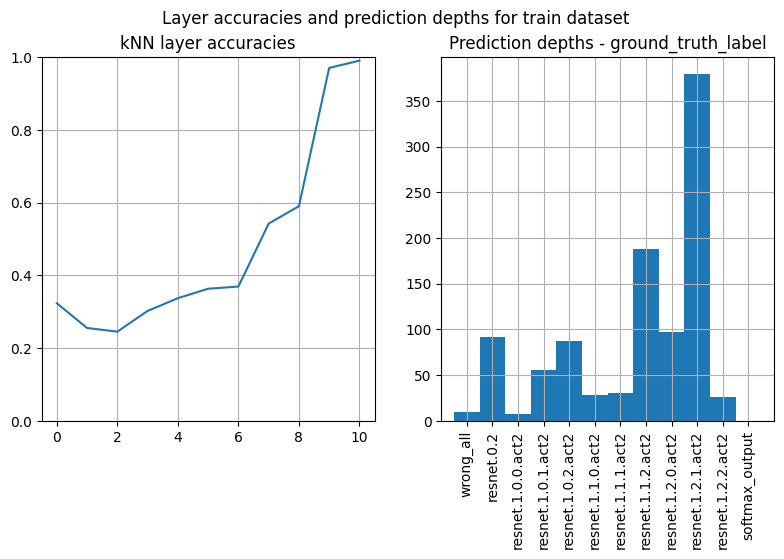

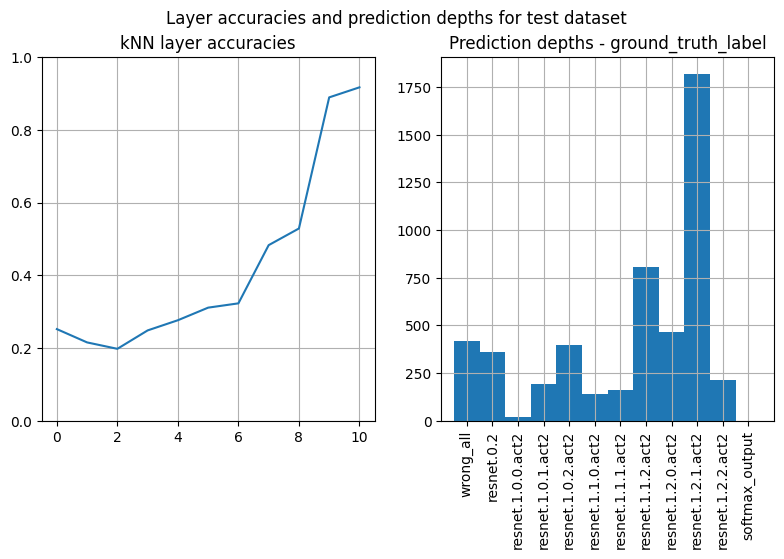

In [32]:
plots = pred_depth._make_plots(res)

In [12]:
pred_depth = pdepth.PredictionDepth(myresnet,
                                    layer_names,
                                    train_dataloader=cf10_trainloader,
                                    test_dataloader=cf10_valloader, 
                                    prediction_depth_mode='model_prediction')

Computing kNN predictions: 100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


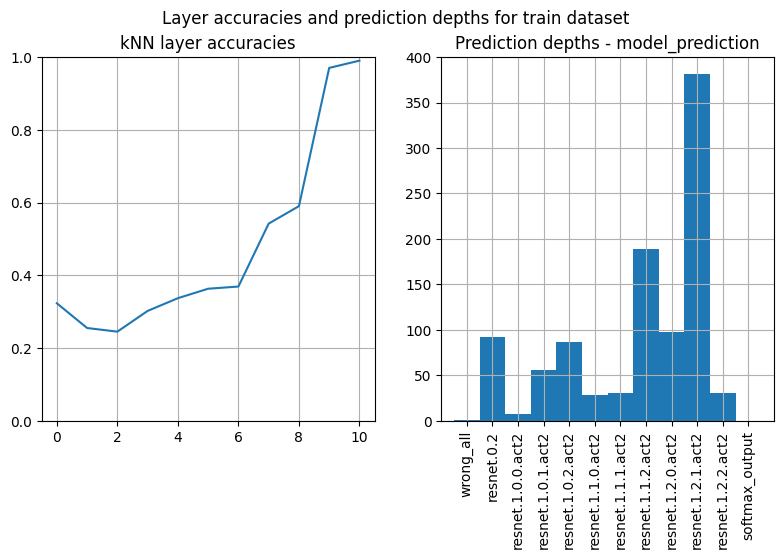

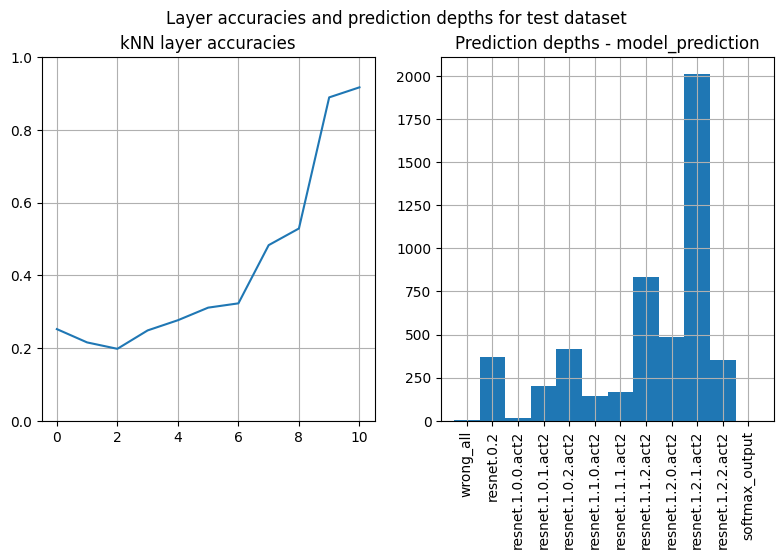

In [13]:
plots2 = pred_depth.make_plots()